# Вариант №10


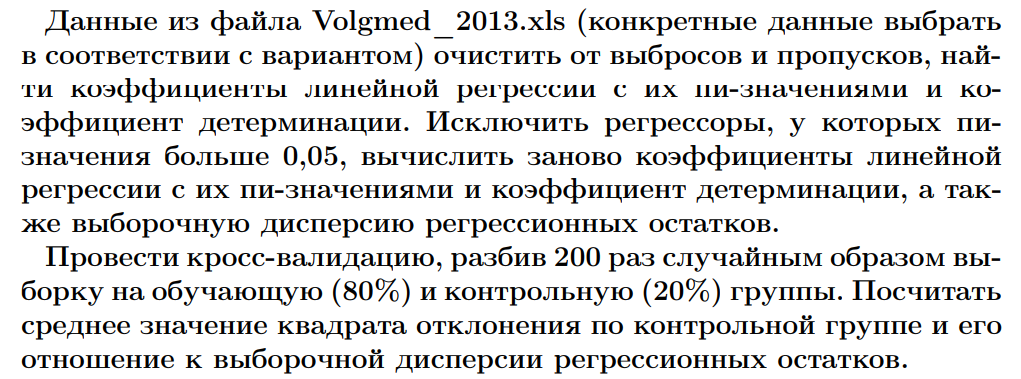

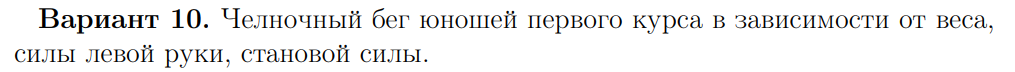


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import statsmodels
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Анализ данных на Python/Volgmed_2013.xlsx', header=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12375 entries, 0 to 12374
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   № п/п                                    193 non-null    float64       
 1   Пол                                      3190 non-null   object        
 2   Год рождения                             3095 non-null   float64       
 3   Факультет                                3510 non-null   object        
 4   Курс                                     3318 non-null   float64       
 5   Группа                                   3310 non-null   float64       
 6   Год поступления                          3400 non-null   object        
 7   Дата обследования                        12009 non-null  datetime64[ns]
 8   Рост, см                                 2543 non-null   object        
 9   Вес, кг                                

In [ ]:
# отбираем нужные данные, удаляем пропуски, преобразуем в тип float
data = data[['Курс', 'Пол', 'Челночный бег, с', 'Вес, кг', 'Сила левой руки, кг', 'Становая сила, кг']]
data = data.dropna(how='any')
data = data[(data['Курс'] == 1)]
data = data[(data['Пол'] == 'муж') | (data['Пол'] == 'муж.')]

data = data[data['Челночный бег, с'].apply(lambda x: isinstance(x, float))]
data['Челночный бег, с'] = data['Челночный бег, с'].astype('float')

data['Вес, кг'] = data['Вес, кг'].astype('float')

data['Становая сила, кг'] = data['Становая сила, кг'].astype('float')

data = data.sort_values(by='Челночный бег, с')
data

,Курс,Пол,"Челночный бег, с","Вес, кг","Сила левой руки, кг","Становая сила, кг"
4047,1.0,муж,18.8,56.7,20.0,125.0
2917,1.0,муж,18.9,63.0,52.0,100.0
407,1.0,муж,19.2,67.5,60.0,107.0
464,1.0,муж,19.3,68.0,63.0,120.0
4033,1.0,муж,19.3,69.7,48.0,140.0
...,...,...,...,...,...,...
2431,1.0,муж,24.4,82.0,40.0,115.0
4073,1.0,муж,24.6,69.5,18.0,70.0
4043,1.0,муж,24.8,67.6,20.0,100.0
3470,1.0,муж,25.5,60.0,13.0,50.0


In [ ]:
# избавляемся от выбросов
data = data[['Челночный бег, с', 'Вес, кг', 'Сила левой руки, кг', 'Становая сила, кг']]
array=data.to_numpy()

for col in data.columns:
  q1 = data[col].quantile(0.25)
  q3 = data[col].quantile(0.75)
  qr = q3 - q1
  lower_limit = q1 - 1.5 * qr
  upper_limit = q3 + 1.5 * qr
  data = data[(data[col] < upper_limit) & (data[col] > lower_limit)]
data

,"Челночный бег, с","Вес, кг","Сила левой руки, кг","Становая сила, кг"
4047,18.8,56.7,20.0,125.0
2917,18.9,63.0,52.0,100.0
407,19.2,67.5,60.0,107.0
464,19.3,68.0,63.0,120.0
4033,19.3,69.7,48.0,140.0
...,...,...,...,...
973,22.8,79.0,25.0,100.0
3372,22.9,84.6,39.0,105.0
967,23.1,72.0,46.0,135.0
4065,23.1,68.5,38.0,80.0


In [ ]:
# линейная регрессия
X = data[['Вес, кг', 'Сила левой руки, кг', 'Становая сила, кг']]
Y = data['Челночный бег, с']

X1 = sm.add_constant(X)
model = sm.OLS(Y.astype(np.float64), X1.astype(np.float64))
results = model.fit()
print(results.summary())
print('\nКоэффициент детерминации', results.rsquared)

                            OLS Regression Results                            
Dep. Variable:       Челночный бег, с   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     4.788
Date:                Wed, 06 Nov 2024   Prob (F-statistic):            0.00304
Time:                        16:57:18   Log-Likelihood:                -254.92
No. Observations:                 202   AIC:                             517.8
Df Residuals:                     198   BIC:                             531.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.4274    

In [ ]:
# исключение регрессоров с p-значениями > 0.05
columns = data.columns
new_data = data.copy()
for i in range(len(results.params)):
    if (results.pvalues.iloc[i] > 0.05):
        new_data = new_data.drop(columns[i], axis=1)
new_data.columns

Index(['Челночный бег, с', 'Становая сила, кг'], dtype='object')

In [ ]:
# построение новой модели
X = new_data.drop('Челночный бег, с', axis=1)
Y = new_data['Челночный бег, с']

X1 = sm.add_constant(X)
model = sm.OLS(Y, X1)
results = model.fit()
print(results.summary())
print('\nКоэффициент детерминации', results.rsquared)
sample_variance = np.var(results.resid, ddof=1)
print(f'Выборочная дисперсия регрессионных остатков: {sample_variance}')

                            OLS Regression Results                            
Dep. Variable:       Челночный бег, с   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     9.126
Date:                Wed, 06 Nov 2024   Prob (F-statistic):            0.00285
Time:                        16:57:18   Log-Likelihood:                -257.49
No. Observations:                 202   AIC:                             519.0
Df Residuals:                     200   BIC:                             525.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                21.9375      0.37

In [ ]:
# кросс-валидация
mse_list = []
for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2)
    model_cv = sm.OLS(y_train.astype(np.float64), X_train.astype(np.float64)).fit()
    predictions = model_cv.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mse_list.append(mse)
mean_mse = np.mean(mse_list)
print(f'Среднее значение квадрата отклонения по контрольной группе: {mean_mse}')
print(f'Отношение MSE к выборочной дисперсии остатков: {mean_mse / sample_variance}')

Среднее значение квадрата отклонения по контрольной группе: 0.7635742535460899
Отношение MSE к выборочной дисперсии остатков: 1.0138812201010559
